# Loading the libs

In [57]:
import nltk
from nltk.corpus import stopwords
import os
import numpy as np
import string
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from copy import deepcopy

import sklearn
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Downloading nltk corpus

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
stopword = set(stopwords.words('english'))
punctuat = set(string.punctuation)

## Listing all files

In [67]:
pos_files = []
for root, dirs, files in os.walk("review_polarity/txt_sentoken/pos"):  
    for filename in files:
        if '.txt' in filename:
            pos_files.append(os.path.join(root, filename))
neg_files = []
for root, dirs, files in os.walk("review_polarity/txt_sentoken/neg"):  
    for filename in files:
        if '.txt' in filename:
            neg_files.append(os.path.join(root, filename))

## Reading the files

In [92]:
data = pd.DataFrame(columns=['text', 'type'])
for filename in pos_files:
    with open(filename, encoding='utf-8') as f:
        data= data.append({'text' : f.read().lower().translate(str.maketrans('','',string.punctuation)), 'type' : 'pos'}, ignore_index=True)
for filename in neg_files:
    with open(filename, encoding='utf-8') as f:
        data= data.append({'text' : f.read().lower().translate(str.maketrans('','',string.punctuation)), 'type' : 'neg'}, ignore_index=True)
data = data.sample(frac=1)

In [8]:
def visualize(label):
  words = ''
  for msg in data[data['type'] == label]['text']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

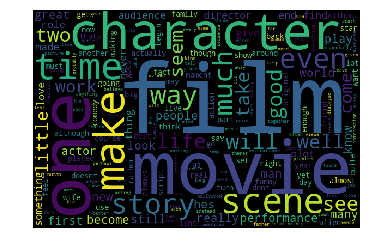

In [9]:
visualize('pos')

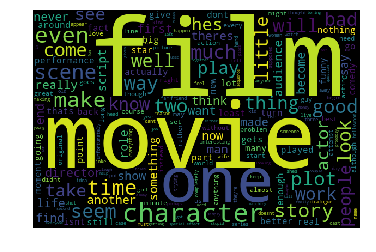

In [10]:
visualize('neg')

In [98]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['type'].as_matrix()

In [70]:
def get_score(index, score, matrix, order):
    X_ = matrix[index]
    indexes = (X_ >= score).nonzero()
    indexes[1].tolist()
    scores = []
    for value in indexes[1]:
        scores.append((vectorizer.get_feature_names()[value], matrix[index, value]))
    scores = sorted(scores, key=lambda tup: tup[1])
    if order == 'ascending':
        return scores
    elif order == 'descending':
        return scores[::-1]

In [71]:
get_score(0, 0.1, X, 'descending')

[('cape', 0.21261249299506046),
 ('the', 0.21143420496776189),
 ('ryan', 0.19367396821228905),
 ('baseball', 0.18200373916843235),
 ('tenley', 0.16941760327138466),
 ('biel', 0.16941760327138466),
 ('cod', 0.16417798027639166),
 ('catch', 0.1421908112225709),
 ('prinze', 0.1304808295669965),
 ('of', 0.12927438069100328),
 ('league', 0.11916681262553594),
 ('is', 0.11769849184637146),
 ('summer', 0.11687169278305742),
 ('falls', 0.11362869112187343)]

In [14]:
threshold = np.linspace(start = 0.0, stop = 1.0, num = 25)
threshold

array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
       0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
       0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
       0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
       0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ])

In [44]:
def find_threshold(model, thresholds, X, y):
    test_accuracy = []
    train_accuracy = []
    for thresh in thresholds:
        X__ = deepcopy(X)
        X__[X__ < thresh] = 0
        X_train, X_test, y_train, y_test = train_test_split(X__, y, test_size = 0.33)
        model.fit(X_train, y_train)
        print("threshold : {}".format(thresh))
        #print("Training accuracy : {}".format(model.score(X_train, y_train)))
        train_accuracy.append(model.score(X_train, y_train))
        #print("Test accuracy : {}".format(model.score(X_test, y_test)))
        test_accuracy.append(model.score(X_test, y_test))
        #print("Classification report for test set")
        #print(classification_report(y_test, model.predict(X_test)))
    return test_accuracy, train_accuracy

In [45]:
model = MultinomialNB()
ta, tra = find_threshold(model, threshold, X, y)

threshold : 0.0
threshold : 0.041666666666666664


KeyboardInterrupt: 

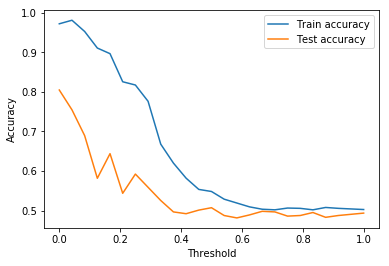

In [32]:
plt.plot(threshold, ta, label='Train accuracy')
plt.plot(threshold, tra, label='Test accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [46]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=20, n_jobs = -1)
ta, tra = find_threshold(model, threshold, X, y)

threshold : 0.0
threshold : 0.041666666666666664
threshold : 0.08333333333333333
threshold : 0.125
threshold : 0.16666666666666666
threshold : 0.20833333333333331
threshold : 0.25
threshold : 0.29166666666666663
threshold : 0.3333333333333333
threshold : 0.375
threshold : 0.41666666666666663
threshold : 0.4583333333333333
threshold : 0.5
threshold : 0.5416666666666666
threshold : 0.5833333333333333
threshold : 0.625
threshold : 0.6666666666666666
threshold : 0.7083333333333333
threshold : 0.75
threshold : 0.7916666666666666
threshold : 0.8333333333333333
threshold : 0.875
threshold : 0.9166666666666666
threshold : 0.9583333333333333
threshold : 1.0


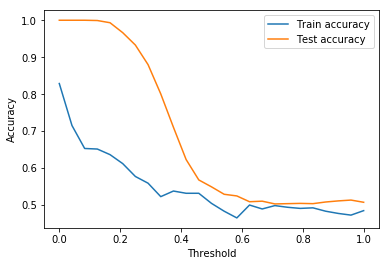

In [47]:
plt.plot(threshold, ta, label='Train accuracy')
plt.plot(threshold, tra, label='Test accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that keeping all features perform better.

In [100]:
train_accuracy = []
test_accuracy = []
kf = KFold(n_splits=5, shuffle = False)
for train_index, test_index in kf.split(X):    
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    model = MultinomialNB()
    model.fit(X_train, y_train)
    train_accuracy.append(model.score(X_train, y_train))
    test_accuracy.append(model.score(X_test, y_test))
    #print("Training accuracy : {}".format(model.score(X_train, y_train)))
    #print("Test accuracy : {}".format(model.score(X_test, y_test)))
    #print("Classification report for test set")
    #print(classification_report(y_test, model.predict(X_test)))
print("Train accuracy : {}".format(np.mean(train_accuracy)))
print("Test accuracy : {}".format(np.mean(test_accuracy)))
print(test_accuracy)


Train accuracy : 0.95975
Test accuracy : 0.7829999999999999
[0.765, 0.7825, 0.73, 0.7975, 0.84]


In [91]:
y_test[y_test == 'pos']

Series([], Name: type, dtype: object)

In [101]:
train_accuracy = []
test_accuracy = []
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):    
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    model = RandomForestClassifier(n_estimators=1000, min_samples_split=20, n_jobs = -1)
    model.fit(X_train, y_train)
    train_accuracy.append(model.score(X_train, y_train))
    test_accuracy.append(model.score(X_test, y_test))
    #print("Training accuracy : {}".format(model.score(X_train, y_train)))
    #print("Test accuracy : {}".format(model.score(X_test, y_test)))
    #print("Classification report for test set")
    #print(classification_report(y_test, model.predict(X_test)))
print("Train accuracy : {}".format(np.mean(train_accuracy)))
print("Test accuracy : {}".format(np.mean(test_accuracy)))
print(test_accuracy)

Train accuracy : 1.0
Test accuracy : 0.8160000000000001
[0.8125, 0.815, 0.79, 0.865, 0.7975]
              precision    recall  f1-score   support

         neg       0.77      0.84      0.80       199
         pos       0.83      0.76      0.79       201

   micro avg       0.80      0.80      0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



In [74]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=10, n_jobs = -1)
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))

Training accuracy : 1.0
Test accuracy : 0.46
Classification report for test set
              precision    recall  f1-score   support

         neg       0.52      0.38      0.44       112
         pos       0.42      0.56      0.48        88

   micro avg       0.46      0.46      0.46       200
   macro avg       0.47      0.47      0.46       200
weighted avg       0.48      0.46      0.46       200



In [52]:
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()

In [56]:
print("True positive : {}, False positive : {} \n True Negative {}, False Negative : {}".format(tp, fp, tn, fn))

True positive : 264, False positive : 37 
 True Negative 285, False Negative : 74


In [10]:
contigency = pd.DataFrame(index=vectorizer.get_feature_names(),data = 0, columns=['pos', 'neg'])

In [97]:
for word in contigency.index:
    for i in range(0, len(sentences)):
        if word in sentences[i] and i == 1:
            contigency.loc[word]['pos'] = contigency.loc[word]['pos'] + 1
        elif word in sentences[i] and i == 0:
            contigency.loc[word]['pos'] = contigency.loc[word]['neg'] + 1

In [100]:
contigency.head(20)

,pos,neg
00,0,0
000,0,0
0009f,0,0
000acre,0,0
000aweek,0,0
000foot,0,0
000paltry,0,0
007,0,0
007esque,0,0
00s,0,0


In [114]:
count_vectorizer_pos = feature_extraction.text.CountVectorizer()
count_vectorizer_neg = feature_extraction.text.CountVectorizer()

In [115]:
X_count_pos = count_vectorizer_pos.fit_transform(sentences[0:1000])
X_count_neg = count_vectorizer_neg.fit_transform(sentences[1000:2000])

In [116]:
for word in contigency.index:
    if word in count_vectorizer_pos.vocabulary_:
        contigency.loc[word]['pos'] = count_vectorizer_pos.vocabulary_[word]
    if word in count_vectorizer_neg.vocabulary_:
        contigency.loc[word]['neg'] = count_vectorizer_neg.vocabulary_[word]

Creating a matrix of size number of review * vocabulary size

For each word, check its presence in each text

In [17]:
word_presence = pd.DataFrame(index=vectorizer.get_feature_names(),data = 0, columns=np.arange(len(sentences)))

In [18]:
word_presence.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0009f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000acre,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000aweek,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
for i in range(0, len(sentences)):
    word_tokens = nltk.word_tokenize(sentences[i]) 
    for word in word_presence.index:
        if word in word_tokens:
            word_presence.loc[word][i] = 1

# Trying the same but with filtering the data

In [ ]:
filtered_sentence = [w for w in word_tokens if not w in stopword]
filtered_sentence = [w for w in word_tokens if not w in punctuat]

In [ ]:
filterd = []
y = []
for sentence in pos_sentences:
    word_tokens = nltk.word_tokenize(sentence) 
    filtered_sentence = [w.lower() for w in word_tokens if not w in stopword]
    filtered_sentence = [w.lower() for w in word_tokens if not w in punctuat]
    filterd.append(filtered_sentence)
    y.append(1)
for sentence in neg_sentences:
    word_tokens = nltk.word_tokenize(sentence) 
    filtered_sentence = [w.lower() for w in word_tokens if not w in stopword]
    filtered_sentence = [w.lower() for w in word_tokens if not w in punctuat]
    filterd.append(filtered_sentence)
    y.append(0)